In [1]:

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

/tmp/ipykernel_74584/2972468286.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/home/baraa.abdelsamad/anaconda3/envs/SAM2-channels/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

model_id = '/home/baraa.abdelsamad/florence-2/model_checkpoints/epoch_best'
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


def florence2(task_prompt, image, text_input=None):
    """
    Calling the Microsoft Florence2 model
    """
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")

    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids,
                                            skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height))

    return parsed_answer

In [3]:
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

RGB


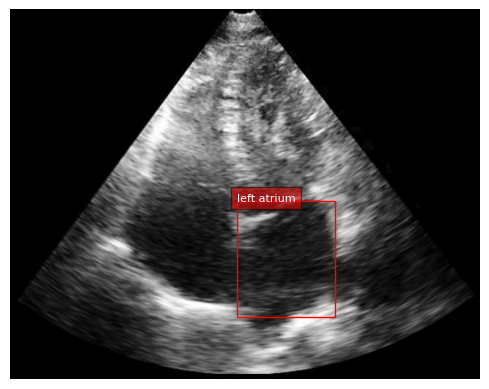

RGB


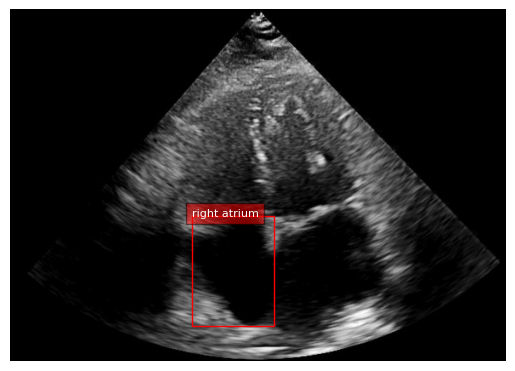

RGB


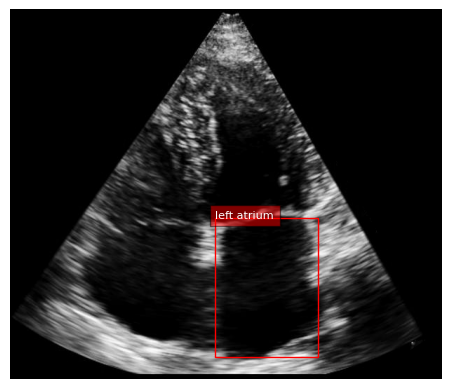

RGB


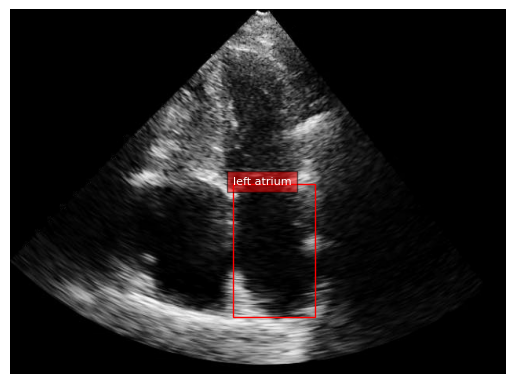

RGB


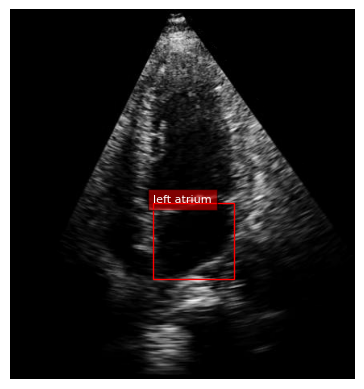

In [4]:
import pandas as pd
from PIL import Image

chamber = "RA"
# Load the Test Data
csv_file = r"/home/baraa.abdelsamad/SAM2-ChannelBased/data/{}_test.csv".format(chamber)  # Replace with your test CSV file path
df = pd.read_csv(csv_file)

# Assuming the CSV has a column named 'file_name' containing the file names
image_directory = '/mnt/rcl-server/workspace/baraa/echo-segmentation-2/images/'
test_data_dir = r"/mnt/rcl-server/workspace/baraa/echo-segmentation-2/"  # Path to test dataset

# List to store sampled image and annotation paths
sampled_data = []

for i in range(5):
    # Get the file name from the CSV
    file_name = df.iloc[i]['file_name']
    
    # Construct the full image path
    image_path = f"{image_directory}{file_name}.png"
    annotation_path = os.path.join(test_data_dir, "masks/", file_name + ".png")
    
    # Open the image using PIL
    image = Image.open(image_path)
    image = image.convert('RGB')
    print(image.mode)
    
    # Perform your task with the image
    task_prompt3 = '<OD>'
    od_results = florence2(task_prompt3, image)
    plot_bbox(image, od_results['<OD>'])
    data = od_results['<OD>']
    bbox = data['bboxes']
    sampled_data.append({"image": image_path, "annotation": annotation_path, "bbox":bbox})
    # print(od_results)  # Assuming you want to print the results

In [5]:
import numpy as np
import pandas as pd
import torch
import cv2
import os
from tqdm import tqdm

from peft import LoraConfig, get_peft_model
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
# Create a directory for saving test results
os.makedirs("test-results-pipeline", exist_ok=True)



/raid/home/baraa.abdelsamad/SAM2-ChannelBased/fine-tune-train_segment_anything_2_in_60_lines_of_code-main/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [6]:

# Load the model
sam2_checkpoint = "/home/baraa.abdelsamad/SAM2-ChannelBased/ckpts/sam2_hiera_small.pt"  # Path to the trained model checkpoint
model_cfg = "sam2_hiera_s.yaml"  # Path to the model configuration file


# sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")  # Load model
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")  # Load model
# Define the LoRA configuration (should match the one used during training)
config = LoraConfig(
    r=8, 
    lora_alpha=8,   
    target_modules=[
        "sam_mask_decoder.transformer.layers.0.self_attn.q_proj",
        "sam_mask_decoder.transformer.layers.0.self_attn.k_proj",
        "sam_mask_decoder.transformer.layers.0.self_attn.v_proj",
        "sam_mask_decoder.transformer.layers.0.self_attn.out_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_token_to_image.v_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_token_to_image.out_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_image_to_token.q_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_image_to_token.k_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_image_to_token.v_proj",
        "sam_mask_decoder.transformer.layers.0.cross_attn_image_to_token.out_proj",
        "memory_attention.layers.0.self_attn.q_proj",
        "memory_attention.layers.0.self_attn.k_proj",
        "memory_attention.layers.0.self_attn.v_proj",
        "memory_attention.layers.0.self_attn.out_proj",
        "memory_attention.layers.0.cross_attn_image.q_proj",
        "memory_attention.layers.0.cross_attn_image.k_proj",
        "memory_attention.layers.0.cross_attn_image.v_proj",
        "memory_attention.layers.0.cross_attn_image.out_proj"
    ],
    lora_dropout=0.0,
    bias="none",
)

# Apply the LoRA configuration to the model
model = get_peft_model(sam2_model, config)

lora_checkpoint = torch.load('/home/baraa.abdelsamad/SAM2-ChannelBased/test-results-correct-bbox/model.torch')

model.load_state_dict(lora_checkpoint)
# Instantiate the predictor
predictor = SAM2ImagePredictor(model)


In [7]:

# Define a function to calculate IoU
def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union > 0 else 0.0
    return iou

# Define a function to calculate Dice coefficient
def calculate_dice(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    dice = (2.0 * intersection) / (gt_mask.sum() + pred_mask.sum())
    return dice

# Define a function to extract bounding box from the mask
def get_bbox(mask):
    # mask_channel = mask[..., 0]  # Use the first channel of the mask do this for LA 
    
    # Get all coordinates in the mask where the value is greater than 0
    coords = np.argwhere(mask > 0)
    
    if coords.size == 0:
        return None  # Return None if the mask is empty or has no positive values

    # Calculate bounding box
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    return [x_min, y_min, x_max, y_max]


In [8]:

def add_label(image, label, position, font_scale=0.8, thickness=2, color=(255, 255, 255)):
    """
    Add a label to the image at the specified position.
    
    Args:
    - image (numpy array): The image to add the label to.
    - label (str): The text label.
    - position (tuple): The (x, y) position for the label.
    - font_scale (float): Font scale (size) of the label text.
    - thickness (int): Thickness of the label text.
    - color (tuple): Color of the text in BGR format.
    
    Returns:
    - image (numpy array): The image with the label added.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(image, label, position, font, font_scale, color, thickness, cv2.LINE_AA)

def binarize_mask_by_highest_label(mask):
    """
    Binarize the mask by converting the highest label (in terms of pixel intensity) to 1 and others to 0.
    
    Args:
    - mask (numpy array): The input mask.
    
    Returns:
    - binary_mask (numpy array): The binarized mask with labels 0 and 1.
    """
    highest_label = np.max(mask)  # Find the highest label in the mask
    
    # Binarize the mask: Convert the highest label to 1, others to 0
    binary_mask = np.where(mask == highest_label, 1, 0).astype(np.uint8)
    
    return binary_mask


In [9]:

# Evaluate on sampled data
iou_scores = []
dice_scores = []
predictor.model.eval()  # Set model to evaluation mode

for i, sample in enumerate(sampled_data):
    # Load image and annotation
    image = cv2.imread(sample["image"], 1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotation = cv2.imread(sample["annotation"], 1)  # Load mask as grayscale
    print(f"is there a mask: {np.unique(annotation[...,2])}")
    # annotation = annotation[...,0] # for LV annotation = cv2.imread(sample["annotation"], 1) 
    annotation = annotation[...,2] # for RA 
    print(f"image shape {image.shape}")

    # Get bounding box from the annotation mask
    bbox = sample['bbox']
    print(f"got bbox: {bbox[0]}")
    # bbox = convert_bboxes_to_pixels(image, bbox)
    # print(f"got unnormalized bbox: {bbox[0]}")

    annotation = binarize_mask_by_highest_label(annotation)
    print(f"mask after binarizing: {np.unique(annotation)}")

    if bbox is None:
        continue  # Skip if no valid bounding box is found

    predictor.set_image(image_rgb)
    prd_masks, scores, logits = predictor.predict(
        box=bbox[0]
    )
    print(f"shape of pred mask: {prd_masks.shape}")
    # Sort predicted masks by score
    # Sort the predicted masks by their scores
    sorted_masks = prd_masks[np.argsort(scores)][::-1].astype(bool)

    # Assuming the highest scoring mask is the most accurate
    pred_mask = sorted_masks[0].astype(np.uint8)
    print(f"pred mask unique is: {np.unique(pred_mask)}")

    # Compare ground truth mask with predicted mask
    iou = calculate_iou(annotation, pred_mask)
    dice = calculate_dice(annotation, pred_mask)
    iou_scores.append(iou)
    dice_scores.append(dice)

    # Overlay masks with specific colors (e.g., blue for GT, red for prediction)
    gt_overlay = cv2.addWeighted(image, 0.7, cv2.merge([annotation * 255, np.zeros_like(annotation), np.zeros_like(annotation)]), 0.3, 0)
    pred_overlay = cv2.addWeighted(image, 0.7, cv2.merge([np.zeros_like(pred_mask), np.zeros_like(pred_mask), pred_mask * 255]), 0.3, 0)

    # Add labels to the overlays
    gt_overlay = add_label(gt_overlay, 'Ground Truth', (10, 30))
    pred_overlay = add_label(pred_overlay, 'Prediction', (10, 30))

    # Concatenate original, ground truth overlay, and predicted overlay
    combined_image = np.concatenate((image, gt_overlay, pred_overlay), axis=1)

    # Save the combined image
    save_path = os.path.join("test-results-pipeline", f"sample_{i+1}_gt_vs_pred_{chamber}.png")
    cv2.imwrite(save_path, combined_image)

# Calculate mean IoU and mean Dice score
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)

print(f"Mean IoU: {mean_iou}")
print(f"Mean Dice: {mean_dice}")

is there a mask: [0 1]
image shape (505, 642, 3)
got bbox: [309.1230163574219, 261.3374938964844, 443.301025390625, 419.4024963378906]
mask after binarizing: [0 1]
shape of pred mask: (3, 505, 642)
pred mask unique is: [0 1]
is there a mask: [0 1]
image shape (498, 702, 3)
got bbox: [256.58099365234375, 292.57501220703125, 373.81500244140625, 447.95098876953125]
mask after binarizing: [0 1]
shape of pred mask: (3, 498, 702)
pred mask unique is: [0 1]
is there a mask: [0 1]
image shape (528, 616, 3)
got bbox: [292.9079895019531, 298.0559997558594, 438.8999938964844, 496.0559997558594]
mask after binarizing: [0 1]
shape of pred mask: (3, 528, 616)
pred mask unique is: [0 1]
is there a mask: [0 1]
image shape (465, 632, 3)
got bbox: [283.4520263671875, 222.50250244140625, 388.364013671875, 392.2275085449219]
mask after binarizing: [0 1]
shape of pred mask: (3, 465, 632)
pred mask unique is: [0 1]
is there a mask: [0 1]
image shape (459, 428, 3)
got bbox: [177.406005859375, 239.36849975585